In [1]:

import numpy as np
import argparse
import cv2
import os,shutil
import time
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import Counter
from itertools import chain
import rawpy
import imageio
import util_segment as us
from sklearn import preprocessing

In [2]:

def getKMeansMask(orig_image , roi_mask ,ratio = 0.5):
    
    #Resizing the image for faster clustering
    image  = orig_image.copy()  
    dim = (int(image.shape[1]*ratio),int(image.shape[0]*ratio))
    image = cv2.resize(image,dim ,interpolation = cv2.INTER_AREA)
     
    (h, w) = image.shape[:2]
    mask = np.zeros((h,w))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # reshape the image into a feature vector so that k-means
    # can be applied
    rows = image.shape[0]
    columns = image.shape[1]
    total_rows = image.shape[0] * image.shape[1]
    image_re2 = []
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    
    ri=0
    ci=0
    for i in range(0,total_rows):
        row = image[i]
        #print()
        row = np.hstack((row,[ri,ci]))
        image_re2.append(row)
        #break
        if ci < columns-1:
            ci+=1
        else:
            ci=0
            if ri < rows-1:
                ri+=1
    
    image_re2 = np.array(image_re2)
    
    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    clt = MiniBatchKMeans(n_clusters = 2)
    labels = clt.fit_predict(image)
    labels = labels.reshape((h,w))
    
    #Finding the most common label which would be the background and making a mask out of it
    most_common_cluster_label = Counter(chain.from_iterable(labels)).most_common(1)[0][0]
    bg_label = most_common_cluster_label 
    mask = us.invertMask(labels,bg_label).astype('uint8')
    
    #Resizing it back to the original image dimensions since we had shrunk it above
    final_mask = cv2.resize(mask, (orig_image.shape[1] , orig_image.shape[0])).astype('int8')
    return final_mask

In [19]:
original_image = None
filename = '/home/sachin/Jimmy Joseph/Felix-3D/images/all_sample_images/_DSC0117.JPG'
original_image = cv2.imread(filename)


image = None
image_with_object = None
thresh = None
holes_only_mask = None
holes = None
k_means_mask = None
obj_only_mask = None

#1.
(he,wi,ch) = original_image.shape

original_image = original_image[100:he-100,100:wi-100,:]

image = original_image.copy()

thresh = np.max( np.array([ us.processImage(image,0), us.processImage(image,1) ,
                   us.processImage(image,2) ]), axis=0 )
#testing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
thresh = cv2.dilate(thresh, kernel)
#writeImage('/home/space/Jimmy Joseph/Projects/Felix-3D/images/' , 'thresh2.jpg' , thresh,'jpg')
roi_mask = cv2.imread('/home/sachin/Jimmy Joseph/Felix-3D/_DC_roi_masks/1_roi_mask_out.png',0)
roi_mask[roi_mask>0] = 255
#2.
k_means_mask = getKMeansMask(image,roi_mask ,0.3)

#3.
obj_only_mask = us.getObjectOnlyMask(thresh.copy())

In [20]:
k_means_mask[k_means_mask==1] = 255
k_means_mask =  k_means_mask.astype('uint8')

In [21]:
us.displayImage(k_means_mask)

In [136]:
ratio = 0.3
#original_image = 
image  = cv2.GaussianBlur(original_image.copy(),(5,5),0) 
dim = (int(image.shape[1]*ratio),int(image.shape[0]*ratio))
image = cv2.resize(image,dim ,interpolation = cv2.INTER_AREA)

(h, w) = image.shape[:2]
mask = np.zeros((h,w))
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# reshape the image into a feature vector so that k-means
# can be applied
rows = image.shape[0]
columns = image.shape[1]
total_rows = image.shape[0] * image.shape[1]
image_re2 = []
image = image.reshape((image.shape[0] * image.shape[1], 3))

# apply k-means using the specified number of clusters and
# then create the quantized image based on the predictions
clt = MiniBatchKMeans(n_clusters = 5)
labels = clt.fit_predict(image)
labels = labels.reshape((h,w))

#Finding the most common label which would be the background and making a mask out of it
#most_common_cluster_label = Counter(chain.from_iterable(labels)).most_common(1)[0][0]
#bg_label = most_common_cluster_label 
#mask = us.invertMask(labels,bg_label).astype('uint8')

#Resizing it back to the original image dimensions since we had shrunk it above

#return final_mask

In [137]:
labels = labels.astype('uint8')

In [138]:
labels = cv2.resize(labels, (original_image.shape[1] , original_image.shape[0])).astype('int8')

from sklearn.cluster import MeanShift, estimate_bandwidth
original_image = None
filename = '/home/sachin/Jimmy Joseph/Felix-3D/images/all_sample_images/_J9A6620.jpg'
original_image = cv2.imread(filename)


image = None
image_with_object = None
thresh = None
holes_only_mask = None
holes = None
k_means_mask = None
obj_only_mask = None

#1.
(he,wi,ch) = original_image.shape

original_image = original_image[100:he-100,100:wi-100,:]

ratio = 0.3
image  = original_image.copy()  
dim = (int(image.shape[1]*ratio),int(image.shape[0]*ratio))
image = cv2.resize(image,dim ,interpolation = cv2.INTER_AREA)

(h, w) = image.shape[:2]
mask = np.zeros((h,w))
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# reshape the image into a feature vector so that k-means
# can be applied
rows = image.shape[0]
columns = image.shape[1]
total_rows = image.shape[0] * image.shape[1]
image_re2 = []
image = image.reshape((image.shape[0] * image.shape[1], 3))
    
#bandwidth = estimate_bandwidth(image, quantile=0.2, n_samples=500)

ms = MeanShift(bin_seeding=True,n_jobs=6)
ms.fit(image)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

In [139]:
im = np.zeros((labels.shape[0],labels.shape[1],3))

In [102]:
us.displayImage(k_means_mask)

In [140]:
colors = [(255,0,0) ,(0,255,0) , (0,0,255) ,  (255,255,0),(0,255,255), (255,0,255),(255,255,255) ]
#init_color=(0,0,0)
for label in np.unique(labels):
    #init_color = tuple([c+20 for c in init_color])
    #colors.append(init_color)
    im[labels==label] = colors[label]
    #break

In [142]:
im =  im.astype('uint8')
us.displayImage(im)

In [33]:
np.unique(roi_mask)

array([  0, 255], dtype=uint8)

In [143]:
c = Counter(chain.from_iterable(labels))

In [144]:
susp_bg_labels = []
def_bg_labels = []
for label in np.unique(labels):
    n_p = c[label]
    val = roi_mask[labels==label]==0#it is not in ROI
    n_val = np.sum(val)
    perc = (n_val/n_p)*100
    print('label:'+str(label)+',perc:'+str(perc))
    if perc > 70:
        susp_bg_labels.append(label)
    if perc > 95:
        def_bg_labels.append(label)

label:0,perc:54.88465922989628
label:1,perc:96.08707282633799
label:2,perc:70.65436766974871
label:3,perc:5.2012429414939465
label:4,perc:86.64877702901349


In [145]:
susp_bg_labels , def_bg_labels

([1, 2, 4], [1])

In [146]:
final_list = []

for label in susp_bg_labels:
    x = k_means_mask == 255
    n_p = np.sum(x)
    val = k_means_mask[labels==label]==255
    n_val = np.sum(val)
    fg_perc = (n_val/n_p)*100
    print('label:'+str(label)+',perc:'+str(fg_perc))
    if fg_perc < 30:
        final_list.append(label)

label:1,perc:0.6962889984823372
label:2,perc:20.258999056724484
label:4,perc:56.31115882943665


In [147]:
final_list

[1, 2]

In [154]:
k5_mask = np.ones((labels.shape[0],labels.shape[1]))

In [155]:
for label in [1]:
    k5_mask[labels==label]=0

In [156]:
us.displayImage(us.convertMasktoImage(k5_mask))

In [153]:
us.displayImage(im)

In [6]:
filename = '/home/sachin/Jimmy Joseph/Felix-3D/out__DC_images/_DSC0117_out.JPG'
original_image = cv2.imread(filename)


In [27]:
filename1 = '/home/sachin/Jimmy Joseph/Felix-3D/images/cup_images/1_00.png'

/home/sachin/.envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


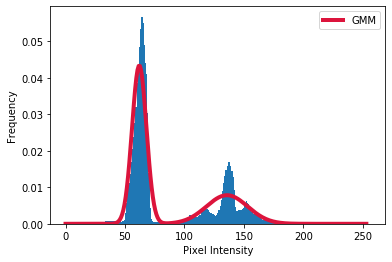

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Read image
img = cv2.imread(filename,0)

hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist[0] = 0     # Removes background pixels

data = img.ravel()
data = data[data != 0]
data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

# Fit GMM
gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=np.expand_dims(data,1))

# Evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))


# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(img.ravel(),255,[2,256], normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()

plt.show()

In [25]:
gmm.means_

array([[135.80511979],
       [ 62.00405434]])

In [26]:
np.mean(gmm.means_)

98.9045870655117

/home/sachin/.envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


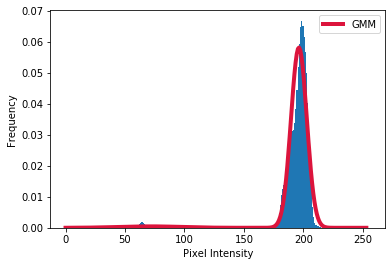

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Read image
img = cv2.imread(filename1,0)

hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist[0] = 0     # Removes background pixels

data = img.ravel()
data = data[data != 0]
data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

# Fit GMM
gmm1 = GaussianMixture(n_components = 2)
gmm1 = gmm1.fit(X=np.expand_dims(data,1))

# Evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm1.score_samples(gmm_x.reshape(-1,1)))


# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(img.ravel(),255,[2,256], normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()

plt.show()

In [37]:
gmm1.sample(2)

(array([[199.02801914],
        [194.41067943]]), array([0, 0]))

In [33]:
gmm1.means_

array([[196.27861392],
       [ 71.12827056]])

In [40]:
import numpy as np
import cv2
import os
path = '/home/sachin/Jimmy Joseph/Felix-3D/images/_DC/'
fgbg = cv2.createBackgroundSubtractorMOG2()
files = sorted(os.listdir(path))
masks = []
for filename in files:
    image = cv2.imread(os.path.join(path,filename),0)
    fgmask = fgbg.apply(image)
    masks.append(fgmask)
    #cv2.imshow('frame',fgmask)


In [47]:
us.displayImage(masks[35])

In [46]:
np.unique(masks[35])

array([  0, 127, 255], dtype=uint8)